# **Walmart: Trip Type Classification**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# DATA

### Reading data

In [3]:
train_data=pd.read_csv(r'/kaggle/input/walmaa/train.csv')
test_data=pd.read_csv(r'/kaggle/input/walmaa/test.csv')

In [4]:
train_data.shape,test_data.shape

((647054, 7), (653646, 6))

In [5]:
train_data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [6]:
test_data.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,1,Friday,7.250339e+10,1,SHOES,3002.0
1,1,Friday,1.707711e+09,1,DAIRY,1526.0
2,1,Friday,8.947000e+10,1,DAIRY,1431.0
3,1,Friday,8.849121e+10,1,GROCERY DRY GOODS,3555.0
4,2,Friday,2.840015e+09,1,DSD GROCERY,4408.0


## Data Description

### **Problem statement**: categorizing shopping trip types based on the items that customers purchased. 
To give a few hypothetical examples of trip types: a customer may make a small daily dinner trip, a weekly large grocery trip, a trip to buy gifts for an upcoming holiday, or a seasonal trip to buy clothes.

Walmart has categorized the trips contained in this data into 38 distinct types using a proprietary method applied to an extended set of data. You are challenged to recreate this categorization/clustering with a more limited set of features. This could provide new and more robust ways to categorize trips.

The training set (train.csv) contains a large number of customer visits with the TripType included. You must predict the TripType for each customer visit in the test set (test.csv). Each visit may only have one TripType. You will not be provided with more information than what is given in the data (e.g. what the TripTypes represent or more product information).

### **Data fields**

#### *TripType* - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.
#### *VisitNumber* - an id corresponding to a single trip by a single customer
#### Weekday - the weekday of the trip
#### *Upc* - the UPC number of the product purchased
#### *ScanCount* - the number of the given item that was purchased. A negative value indicates a product return.
#### *DepartmentDescription* - a high-level description of the item's department
#### *FinelineNumber* - a more refined category for each of the products, created by Walmart

# Exploring Data

## Checking for duplication

## Deduplication

In [7]:
train_d1=train_data.drop_duplicates()

In [8]:
train_d1.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [9]:
train_d1.shape

(641350, 7)

In [10]:
duplicates_train=train_data.shape[0]-train_d1.shape[0]
print(duplicates_train)

5704


In [11]:
train_d1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641350 entries, 0 to 647053
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TripType               641350 non-null  int64  
 1   VisitNumber            641350 non-null  int64  
 2   Weekday                641350 non-null  object 
 3   Upc                    638472 non-null  float64
 4   ScanCount              641350 non-null  int64  
 5   DepartmentDescription  640084 non-null  object 
 6   FinelineNumber         638472 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 39.1+ MB


In [12]:
641350-640084

1266

In [13]:
missing_values = {"Upc":2878,"DepartmentDescription":1266,"FinelineNumber":2878}

In [14]:
train_d1.describe()

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,641350.000000,641350.000000,6.384720e+05,641350.000000,638472.000000
mean,58.298793,96203.070372,3.056157e+10,1.110433,3726.202889
std,156.655874,55547.558892,9.108942e+10,0.701888,2779.571033
min,3.000000,5.000000,8.340000e+02,-12.000000,0.000000
25%,27.000000,49321.000000,3.400001e+09,1.000000,1404.000000
50%,39.000000,97101.000000,7.050102e+09,1.000000,3352.000000
75%,40.000000,144358.000000,3.006502e+10,1.000000,5501.000000
max,999.000000,191347.000000,9.789707e+11,71.000000,9998.000000


# Dealing with missing values

**Missing values in FinelineNumber are most. filling them with most frequent value in that column.**

In [15]:
train_d1.FinelineNumber.value_counts()

5501.0    8228
1508.0    5031
135.0     4509
808.0     4377
0.0       3827
          ... 
3517.0       1
1152.0       1
9718.0       1
5578.0       1
6674.0       1
Name: FinelineNumber, Length: 5195, dtype: int64

In [16]:
#most occouring value for FinelineNumber is 8228 whose count is 5501
train_d1['FinelineNumber']=train_data['FinelineNumber'].fillna(8228)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
train_d1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641350 entries, 0 to 647053
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TripType               641350 non-null  int64  
 1   VisitNumber            641350 non-null  int64  
 2   Weekday                641350 non-null  object 
 3   Upc                    638472 non-null  float64
 4   ScanCount              641350 non-null  int64  
 5   DepartmentDescription  640084 non-null  object 
 6   FinelineNumber         641350 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 39.1+ MB


**Droping rest of the rows with missing values, which are very few compared to total size of dataset**

In [18]:
train_d1.dropna(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
train_d1.shape

(638472, 7)

In [20]:
train_d1.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


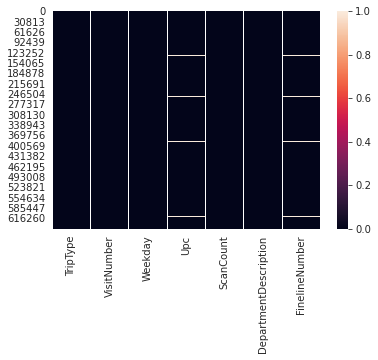

In [21]:
sns.heatmap(train_data.isna())

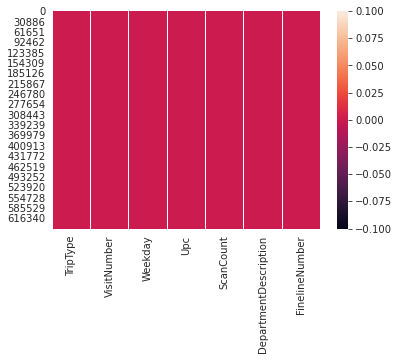

In [21]:
sns.heatmap(train_d1.isna())

## Univariate analysis

### TripType

In [22]:
#number of unique values
train_d1.TripType.nunique()

38

38 different class labels 

In [23]:
#all unique values
train_d1.TripType.unique()

array([999,  30,  26,   8,  35,  41,  21,   6,  42,   7,   9,  39,  25,
        38,  15,  36,  20,  37,  32,  40,   5,   3,   4,  24,  33,  43,
        31,  27,  34,  18,  29,  44,  19,  23,  22,  28,  14,  12])

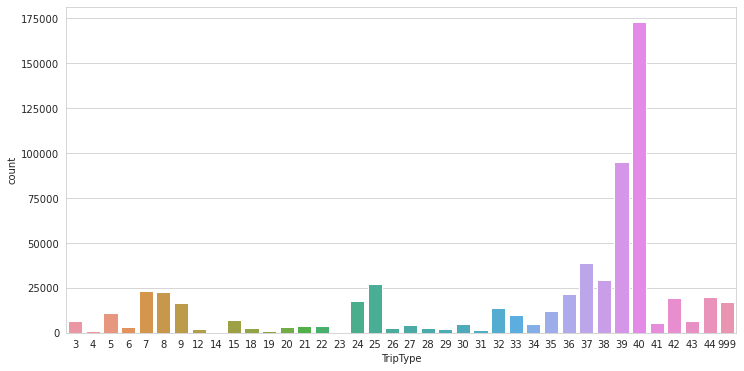

In [24]:
plt.figure(figsize=(12,6))
sns.countplot(train_d1.TripType)

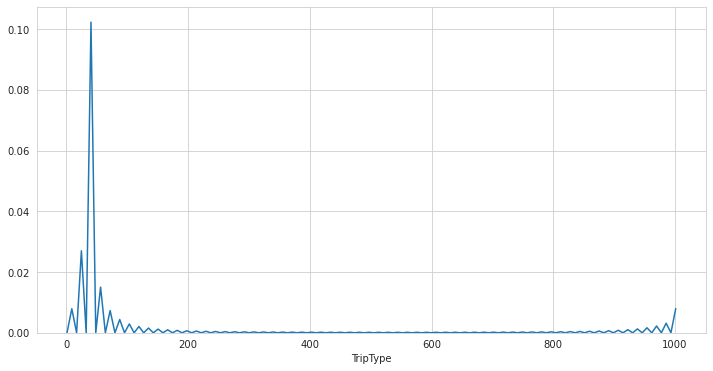

In [25]:
plt.figure(figsize=(12,6))
sns.distplot(train_d1.TripType,hist=False)

**Imbalanced data**. Distribution of target variable is right skewed. there are too many classes for which there are very few datapoints
TripType 36 to 40 have most datapoints.

### VisitNumber

In [27]:
train_d1.VisitNumber.nunique()

94247

In [28]:
train_d1.shape[0]

638472

VisitNumber is a categorical variable

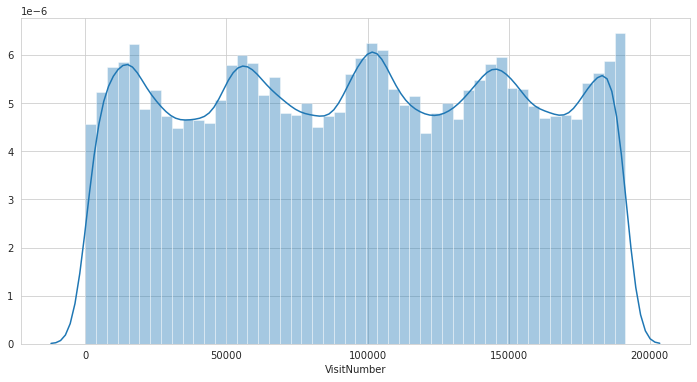

In [29]:
plt.figure(figsize=(12,6))
sns.distplot(train_d1.VisitNumber)

***VisitNumber shows approximately uniform distribution***

In [30]:
train_d1.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


### Weekday distribution 

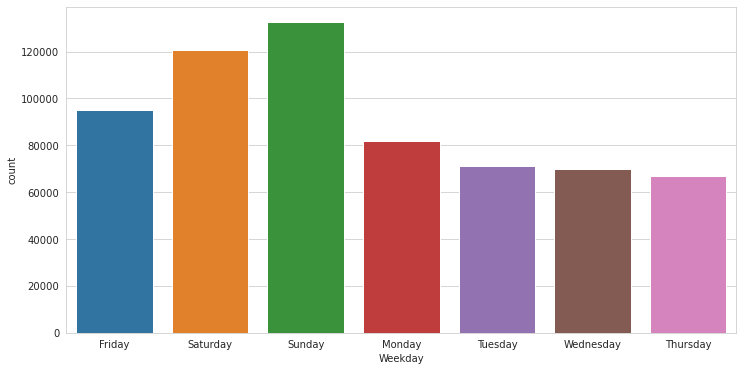

In [31]:
plt.figure(figsize=(12,6))
sns.countplot(train_d1.Weekday)

In [32]:
train_d1.groupby('Weekday')['Weekday'].count()

Weekday
Friday        94909
Monday        82020
Saturday     120568
Sunday       132571
Thursday      67045
Tuesday       71365
Wednesday     69994
Name: Weekday, dtype: int64

In [33]:
def weekday_to_num(x):
  if x=='Monday':
    return 0
  elif x=='Tuesday':
    return 1
  elif x=='Wednesday':
    return 2
  elif x=='Thursday':
    return 3
  elif x=='Friday':
    return 4
  elif x=='Saturday':
    return 5
  elif x=='Sunday':
    return 6 

In [34]:
train_d1['weekday_num']=train_d1.Weekday.apply(weekday_to_num)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
train_d1.shape

(638472, 8)

In [36]:
train_d1.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4


In [37]:
train_d1.Weekday.unique()

array(['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday'], dtype=object)

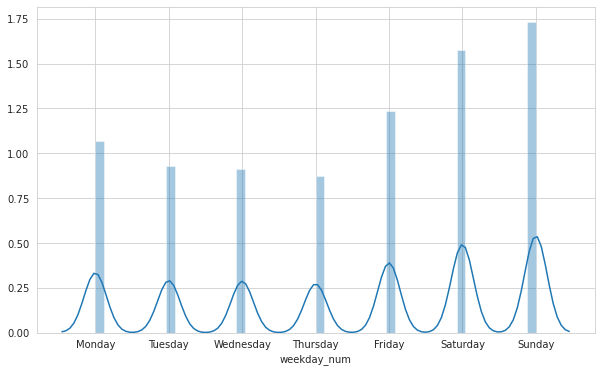

In [38]:
fig,axs=plt.subplots(figsize=(10,6))
sns.distplot(train_d1['weekday_num'],ax=axs)
ticks=list(range(0,7))
axs.set_xticks(ticks)
x_tick_label=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
axs.set_xticklabels(x_tick_label)
plt.show()

***As Expected there is more probabilty of visits for weekends. Thursday is the day for lowest number of visits***

### ScanCount

In [39]:
train_d1.ScanCount.nunique()

39

In [40]:
train_d1.ScanCount.unique()

array([ -1,   1,   2,   3,   5,   6,   4,  14,  -2,   9,   7,  10,   8,
        -3,  -5,  11,  16,  -4,  13,  15,  30,  12,  20,  -6, -12,  19,
        46,  23,  -7,  22,  25,  24,  31,  -9,  51,  17,  18,  71, -10])

In [41]:
train_d1.ScanCount.value_counts()

 1     553701
 2      52771
-1      13920
 3       9406
 4       4525
 5       1377
 6        864
-2        791
 8        246
 7        228
-3        136
 10       130
 9         88
-4         73
 12        60
 11        45
-5         16
 14        15
 13        13
 15        12
-6          9
 20         7
 16         6
 18         4
 24         4
 19         4
 25         3
 17         3
 23         3
 22         2
-9          2
 30         1
 46         1
 51         1
 71         1
-12         1
-10         1
-7          1
 31         1
Name: ScanCount, dtype: int64

In [42]:
train_d1.min().ScanCount

-12

In [43]:
train_d1.max().ScanCount

71

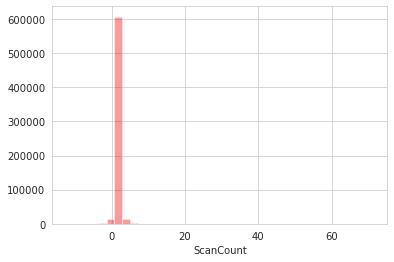

In [44]:
# set the background style of the plot
sns.set_style('whitegrid')
sns.distplot(train_d1['ScanCount'], bins=39, kde=False,color ='red')

***ScanCount data is widely distributed between -12 to 71. 71 seems to be an outlier. so to get clearer view of the distribution plottting distribution in two parts***

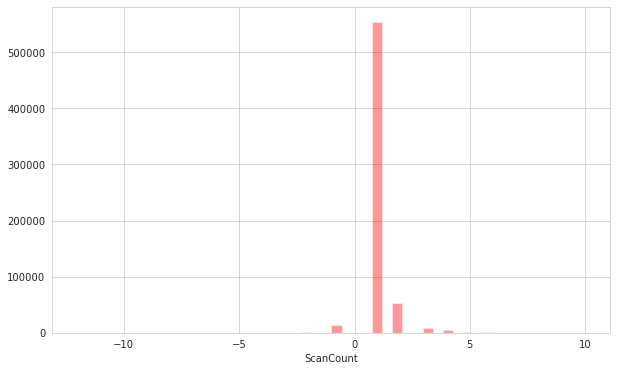

In [45]:
plt.figure(figsize=(10,6))
sns.distplot(train_d1[train_d1.ScanCount<=10].ScanCount,kde=False,color ='red')


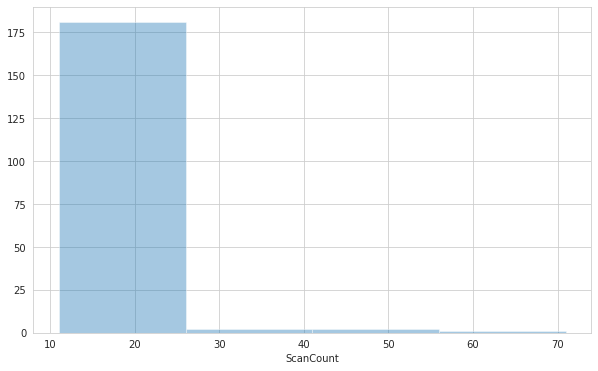

In [60]:
plt.figure(figsize=(10,6))
sns.distplot(train_d1[train_d1.ScanCount>10].ScanCount,bins=4,kde=False)


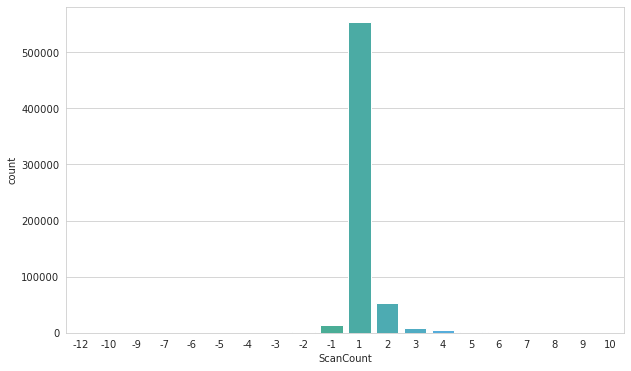

In [46]:
plt.figure(figsize=(10,6))
sns.countplot(train_d1[train_d1.ScanCount<=10].ScanCount)

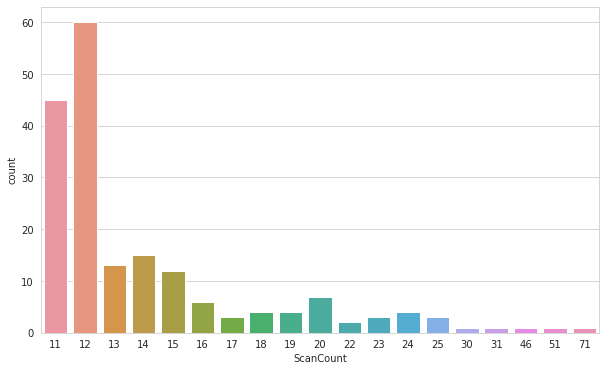

In [47]:
plt.figure(figsize=(10,6))
sns.countplot(train_d1[train_d1.ScanCount>10].ScanCount)

***As we can see, there are visits for ScanCount of 1 the most. and as number of ScanCount increases, the count of data points decreases. Also not many data points are there for returned products, since negative ScanCounts are not much.***

In [48]:
train_d1.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4


### DepartmentDescription	

In [49]:
train_d1.DepartmentDescription.nunique()

68

In [50]:
train_d1.DepartmentDescription.unique()

array(['FINANCIAL SERVICES', 'SHOES', 'PERSONAL CARE',
       'PAINT AND ACCESSORIES', 'DSD GROCERY', 'MEAT - FRESH & FROZEN',
       'DAIRY', 'PETS AND SUPPLIES', 'HOUSEHOLD CHEMICALS/SUPP',
       'IMPULSE MERCHANDISE', 'PRODUCE', 'CANDY, TOBACCO, COOKIES',
       'GROCERY DRY GOODS', 'BOYS WEAR', 'FABRICS AND CRAFTS',
       'JEWELRY AND SUNGLASSES', 'MENS WEAR', 'ACCESSORIES',
       'HOME MANAGEMENT', 'FROZEN FOODS', 'SERVICE DELI',
       'INFANT CONSUMABLE HARDLINES', 'PRE PACKED DELI', 'COOK AND DINE',
       'PHARMACY OTC', 'LADIESWEAR', 'COMM BREAD', 'BAKERY',
       'HOUSEHOLD PAPER GOODS', 'CELEBRATION', 'HARDWARE', 'BEAUTY',
       'AUTOMOTIVE', 'BOOKS AND MAGAZINES', 'SEAFOOD', 'OFFICE SUPPLIES',
       'LAWN AND GARDEN', 'SHEER HOSIERY', 'WIRELESS', 'BEDDING',
       'BATH AND SHOWER', 'HORTICULTURE AND ACCESS', 'HOME DECOR', 'TOYS',
       'INFANT APPAREL', 'LADIES SOCKS', 'PLUS AND MATERNITY',
       'ELECTRONICS', 'GIRLS WEAR, 4-6X  AND 7-14', 'BRAS & SHAPEWEAR',
    

In [51]:
train_d1.DepartmentDescription.value_counts()

GROCERY DRY GOODS         70034
DSD GROCERY               67682
PRODUCE                   50826
DAIRY                     43599
PERSONAL CARE             41887
                          ...  
LARGE HOUSEHOLD GOODS        77
CONCEPT STORES               35
SEASONAL                     29
OTHER DEPARTMENTS            29
HEALTH AND BEAUTY AIDS        2
Name: DepartmentDescription, Length: 68, dtype: int64

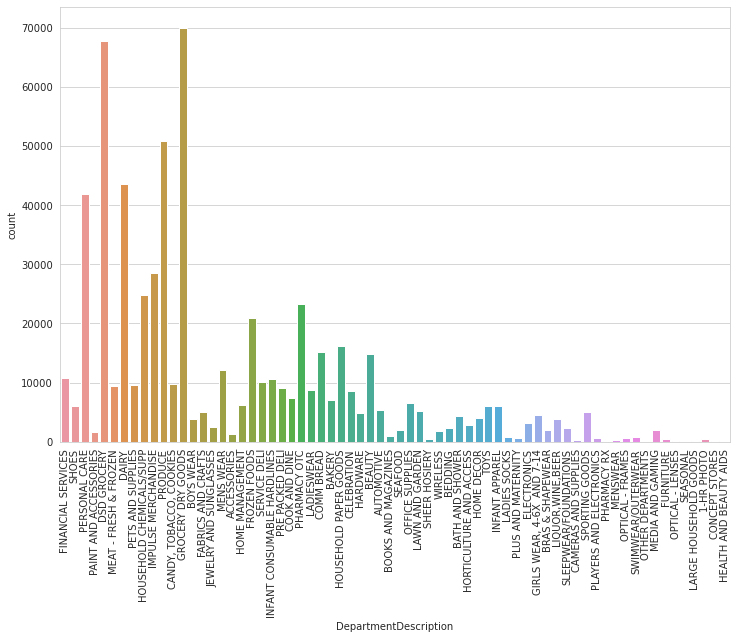

In [52]:
plt.figure(figsize=(12,8))
sns.countplot(x='DepartmentDescription',data=train_d1)
plt.xticks(rotation=90)
plt.show()

In [53]:
train_d1.groupby('DepartmentDescription')['DepartmentDescription'].count()

DepartmentDescription
1-HR PHOTO                387
ACCESSORIES              1294
AUTOMOTIVE               5366
BAKERY                   7109
BATH AND SHOWER          4426
                         ... 
SLEEPWEAR/FOUNDATIONS    2352
SPORTING GOODS           5031
SWIMWEAR/OUTERWEAR        859
TOYS                     6042
WIRELESS                 1889
Name: DepartmentDescription, Length: 68, dtype: int64

In [54]:
department_list=list(train_d1['DepartmentDescription'].unique())
department_list

['FINANCIAL SERVICES',
 'SHOES',
 'PERSONAL CARE',
 'PAINT AND ACCESSORIES',
 'DSD GROCERY',
 'MEAT - FRESH & FROZEN',
 'DAIRY',
 'PETS AND SUPPLIES',
 'HOUSEHOLD CHEMICALS/SUPP',
 'IMPULSE MERCHANDISE',
 'PRODUCE',
 'CANDY, TOBACCO, COOKIES',
 'GROCERY DRY GOODS',
 'BOYS WEAR',
 'FABRICS AND CRAFTS',
 'JEWELRY AND SUNGLASSES',
 'MENS WEAR',
 'ACCESSORIES',
 'HOME MANAGEMENT',
 'FROZEN FOODS',
 'SERVICE DELI',
 'INFANT CONSUMABLE HARDLINES',
 'PRE PACKED DELI',
 'COOK AND DINE',
 'PHARMACY OTC',
 'LADIESWEAR',
 'COMM BREAD',
 'BAKERY',
 'HOUSEHOLD PAPER GOODS',
 'CELEBRATION',
 'HARDWARE',
 'BEAUTY',
 'AUTOMOTIVE',
 'BOOKS AND MAGAZINES',
 'SEAFOOD',
 'OFFICE SUPPLIES',
 'LAWN AND GARDEN',
 'SHEER HOSIERY',
 'WIRELESS',
 'BEDDING',
 'BATH AND SHOWER',
 'HORTICULTURE AND ACCESS',
 'HOME DECOR',
 'TOYS',
 'INFANT APPAREL',
 'LADIES SOCKS',
 'PLUS AND MATERNITY',
 'ELECTRONICS',
 'GIRLS WEAR, 4-6X  AND 7-14',
 'BRAS & SHAPEWEAR',
 'LIQUOR,WINE,BEER',
 'SLEEPWEAR/FOUNDATIONS',
 'CAMERAS AN

In [55]:
department_enumerate=list(enumerate(department_list))
department_enumerate

[(0, 'FINANCIAL SERVICES'),
 (1, 'SHOES'),
 (2, 'PERSONAL CARE'),
 (3, 'PAINT AND ACCESSORIES'),
 (4, 'DSD GROCERY'),
 (5, 'MEAT - FRESH & FROZEN'),
 (6, 'DAIRY'),
 (7, 'PETS AND SUPPLIES'),
 (8, 'HOUSEHOLD CHEMICALS/SUPP'),
 (9, 'IMPULSE MERCHANDISE'),
 (10, 'PRODUCE'),
 (11, 'CANDY, TOBACCO, COOKIES'),
 (12, 'GROCERY DRY GOODS'),
 (13, 'BOYS WEAR'),
 (14, 'FABRICS AND CRAFTS'),
 (15, 'JEWELRY AND SUNGLASSES'),
 (16, 'MENS WEAR'),
 (17, 'ACCESSORIES'),
 (18, 'HOME MANAGEMENT'),
 (19, 'FROZEN FOODS'),
 (20, 'SERVICE DELI'),
 (21, 'INFANT CONSUMABLE HARDLINES'),
 (22, 'PRE PACKED DELI'),
 (23, 'COOK AND DINE'),
 (24, 'PHARMACY OTC'),
 (25, 'LADIESWEAR'),
 (26, 'COMM BREAD'),
 (27, 'BAKERY'),
 (28, 'HOUSEHOLD PAPER GOODS'),
 (29, 'CELEBRATION'),
 (30, 'HARDWARE'),
 (31, 'BEAUTY'),
 (32, 'AUTOMOTIVE'),
 (33, 'BOOKS AND MAGAZINES'),
 (34, 'SEAFOOD'),
 (35, 'OFFICE SUPPLIES'),
 (36, 'LAWN AND GARDEN'),
 (37, 'SHEER HOSIERY'),
 (38, 'WIRELESS'),
 (39, 'BEDDING'),
 (40, 'BATH AND SHOWER'),
 (

In [56]:
department_dict={v:k for k,v in department_enumerate}
department_dict

{'FINANCIAL SERVICES': 0,
 'SHOES': 1,
 'PERSONAL CARE': 2,
 'PAINT AND ACCESSORIES': 3,
 'DSD GROCERY': 4,
 'MEAT - FRESH & FROZEN': 5,
 'DAIRY': 6,
 'PETS AND SUPPLIES': 7,
 'HOUSEHOLD CHEMICALS/SUPP': 8,
 'IMPULSE MERCHANDISE': 9,
 'PRODUCE': 10,
 'CANDY, TOBACCO, COOKIES': 11,
 'GROCERY DRY GOODS': 12,
 'BOYS WEAR': 13,
 'FABRICS AND CRAFTS': 14,
 'JEWELRY AND SUNGLASSES': 15,
 'MENS WEAR': 16,
 'ACCESSORIES': 17,
 'HOME MANAGEMENT': 18,
 'FROZEN FOODS': 19,
 'SERVICE DELI': 20,
 'INFANT CONSUMABLE HARDLINES': 21,
 'PRE PACKED DELI': 22,
 'COOK AND DINE': 23,
 'PHARMACY OTC': 24,
 'LADIESWEAR': 25,
 'COMM BREAD': 26,
 'BAKERY': 27,
 'HOUSEHOLD PAPER GOODS': 28,
 'CELEBRATION': 29,
 'HARDWARE': 30,
 'BEAUTY': 31,
 'AUTOMOTIVE': 32,
 'BOOKS AND MAGAZINES': 33,
 'SEAFOOD': 34,
 'OFFICE SUPPLIES': 35,
 'LAWN AND GARDEN': 36,
 'SHEER HOSIERY': 37,
 'WIRELESS': 38,
 'BEDDING': 39,
 'BATH AND SHOWER': 40,
 'HORTICULTURE AND ACCESS': 41,
 'HOME DECOR': 42,
 'TOYS': 43,
 'INFANT APPAREL': 4

In [57]:
department_dict.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

In [58]:
def department_num(x):
  return department_dict[x]
  

In [59]:
train_d1['Department_num']=train_d1['DepartmentDescription'].apply(department_num)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
train_d1.shape

(638472, 9)

In [61]:
train_d1.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3


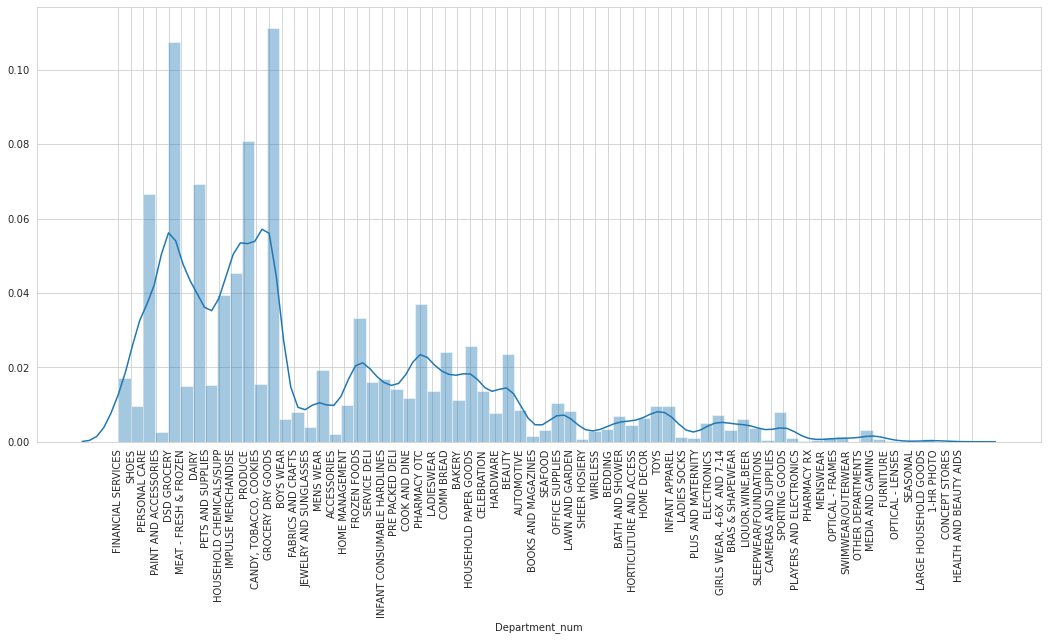

In [62]:
fig,axs=plt.subplots(figsize=(18,8))
sns.distplot(train_d1['Department_num'],bins=68,ax=axs)
ticks=list(range(0,69))
axs.set_xticks(ticks)
x_tick_label=train_d1.DepartmentDescription.unique()
axs.set_xticklabels(x_tick_label)
plt.xticks(rotation=90)
plt.show()

Distribution of DepartmentDescription in somewhat **left skewed**, **PERSONAL CARE, DSD GROCERIES, DAIRY, PRODUCE, GROCERY DRY GOODS** these categories in DepartmentDescription dominate the data.

### FinelineNumber

In [63]:
train_d1.FinelineNumber.nunique()

5195

In [85]:
train_d1.FinelineNumber.unique()

array([1000., 8931., 4504., ..., 8257., 4314., 7130.])

Too many categories in FinelineNumber

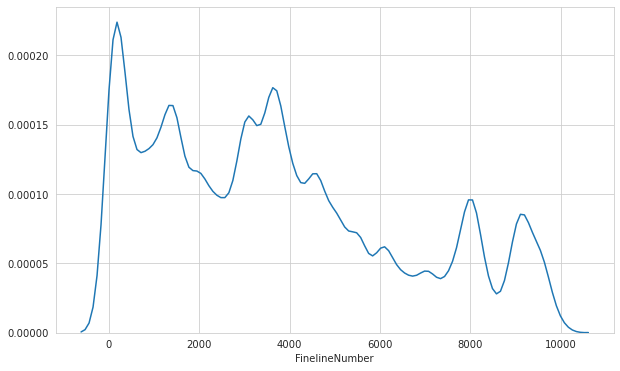

In [64]:
plt.figure(figsize=(10,6))
sns.distplot(train_d1.FinelineNumber,hist=False)

we may say that this is a **multimodal distribution**. certain values appear more frequently than others.

### Upc

In [65]:
train_d1.Upc.nunique()

97714

In [66]:
train_d1.Upc.unique()

array([6.81131529e+10, 6.05388160e+10, 7.41081110e+09, ...,
       8.85306278e+10, 8.87439527e+10, 5.44000008e+09])

In [91]:
train_d1.shape

(638472, 9)

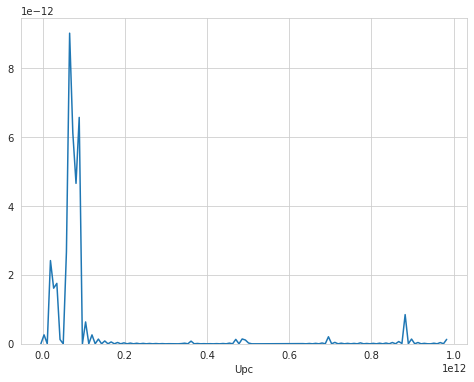

In [67]:
plt.figure(figsize=(8,6))
sns.distplot(train_d1.Upc,hist=False)

In [68]:
train_d1.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3


# featurization

### creating a new feature 'num_of_products' which shows number of products purchased for each 'VisitNumber' based on 'Upc' 

In [69]:
# seeing for each VisitNumber how many products were purchased based on Upc number of product purchased
products_per_visit=train_d1.groupby(['VisitNumber'])['Upc'].count()
products_per_visit

VisitNumber
5          1
7          2
8         22
9          3
10         3
          ..
191343     7
191344     5
191345    13
191346    17
191347     2
Name: Upc, Length: 94247, dtype: int64

In [70]:
products_per_visit_dict=dict(products_per_visit)

In [71]:
train_d1['num_of_products_for_VisitNumber']=train_d1['VisitNumber'].apply(lambda x:products_per_visit_dict.get(x,0))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# train_data.drop(columns=['num_of_products'],inplace=True)

In [72]:
train_d1.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,22
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,22


In [73]:
train_d1.num_of_products_for_VisitNumber.nunique()

101

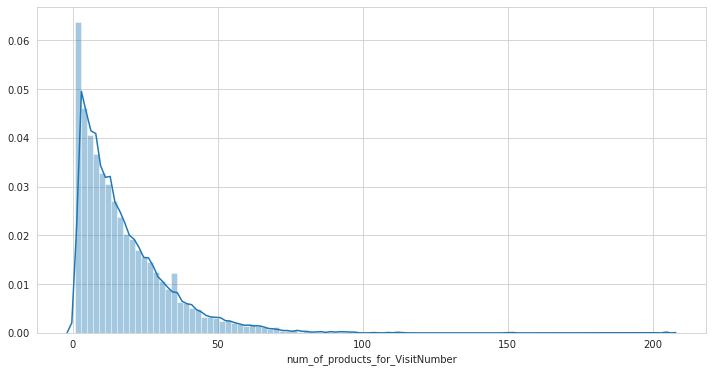

In [74]:
plt.figure(figsize=(12,6))
sns.distplot(train_d1.num_of_products_for_VisitNumber,bins=99)

As expected the distribution of number of products purchased for each VisitNumer is left skewed. there is more probability of buying less number of products

Seems like num_of_products purchased shows lognormal distribution, checking for same.

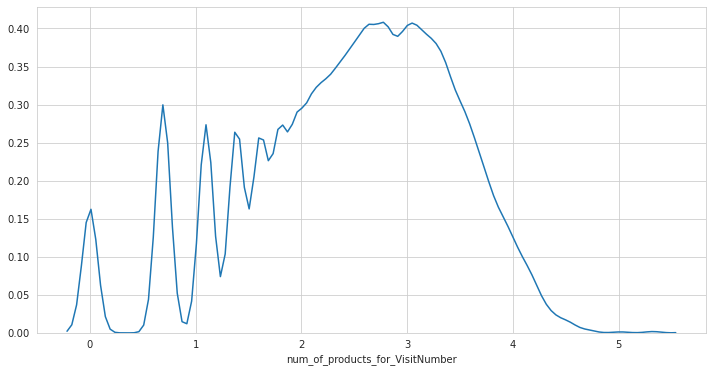

In [75]:
plt.figure(figsize=(12,6))
sns.distplot(np.log(train_d1.num_of_products_for_VisitNumber),hist=False)

num_of_products does not show lognormal distribution.

**Checking if num_of_products is somehow related to the day on which shopping was done**

In [76]:
train_d1.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,22
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,22


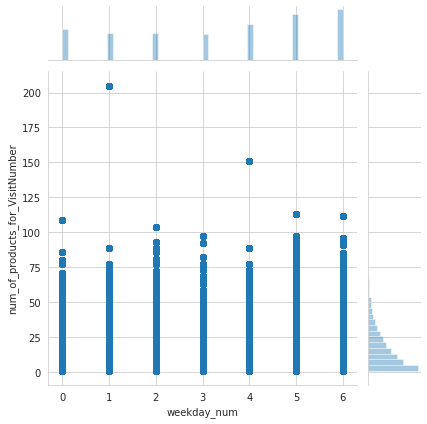

In [77]:
sns.jointplot(y='num_of_products_for_VisitNumber',x='weekday_num',data=train_d1)

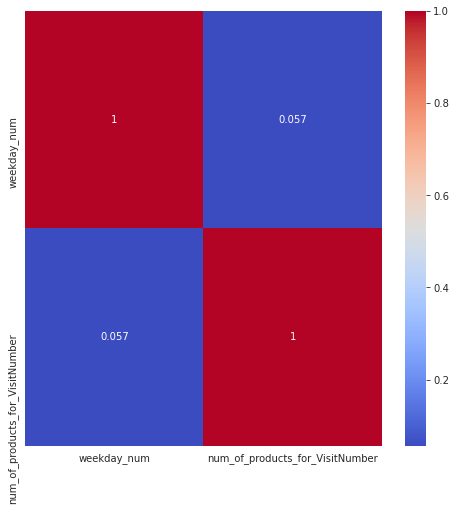

In [78]:
# Create a DataFrame with the two variables
df = pd.DataFrame({'weekday_num': train_d1['weekday_num'], 'num_of_products_for_VisitNumber': train_d1['num_of_products_for_VisitNumber']})

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

plt.show()


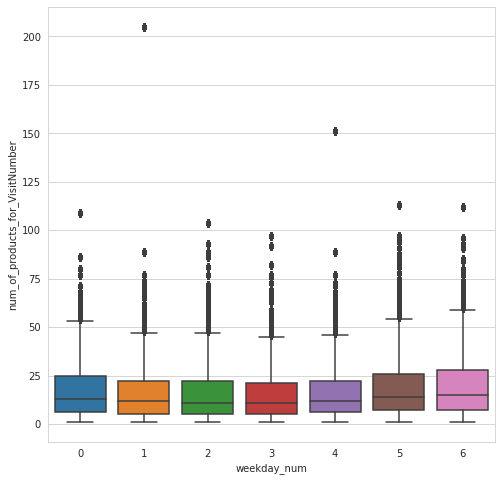

In [79]:
plt.figure(figsize=(8,8))
sns.boxplot(x='weekday_num',y='num_of_products_for_VisitNumber',data=train_d1)

On weekends and on mondays there seem to be more products bought per VisitNumber

In [80]:
train_d1.FinelineNumber.nunique()

5195

In [81]:
train_d1.Department_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

In [82]:
groupby_dept=train_d1.groupby(['Department_num'])

fineline_dict is dictionary where key is Depart_num and value is unique number of FinelineNumber in that department 

In [83]:
fineline_dict={}
for i in range(68):
  gr=groupby_dept.get_group(i)
  c=gr['FinelineNumber'].count()
  un=gr['FinelineNumber'].nunique()
  #print(f"group: {i}, unique FinelineNumber: {un}")
  fineline_dict[i]=un

fineline_dict

{0: 26,
 1: 478,
 2: 303,
 3: 127,
 4: 359,
 5: 154,
 6: 108,
 7: 211,
 8: 196,
 9: 111,
 10: 504,
 11: 72,
 12: 404,
 13: 172,
 14: 341,
 15: 218,
 16: 399,
 17: 84,
 18: 183,
 19: 95,
 20: 81,
 21: 188,
 22: 45,
 23: 307,
 24: 462,
 25: 258,
 26: 51,
 27: 94,
 28: 114,
 29: 167,
 30: 313,
 31: 176,
 32: 247,
 33: 76,
 34: 37,
 35: 288,
 36: 260,
 37: 22,
 38: 120,
 39: 183,
 40: 80,
 41: 167,
 42: 191,
 43: 282,
 44: 185,
 45: 106,
 46: 62,
 47: 169,
 48: 208,
 49: 57,
 50: 50,
 51: 125,
 52: 30,
 53: 355,
 54: 43,
 55: 4,
 56: 60,
 57: 127,
 58: 29,
 59: 2,
 60: 59,
 61: 31,
 62: 3,
 63: 13,
 64: 1,
 65: 12,
 66: 1,
 67: 2}

Basically fineline number corresponds to products so the dict represents that for each department how many unique variety of products we have in that dept.

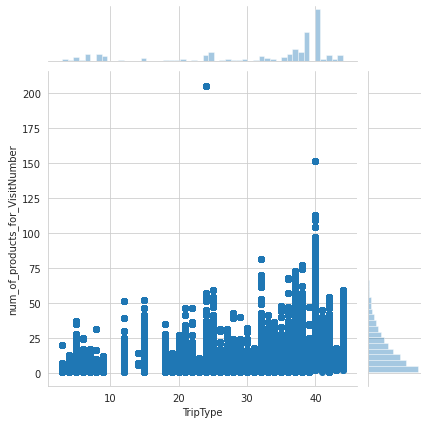

In [84]:
sns.jointplot(y='num_of_products_for_VisitNumber',x='TripType',data=train_d1[train_d1['TripType']<900])

num_of_products seem to increase as category number of TripType increase.

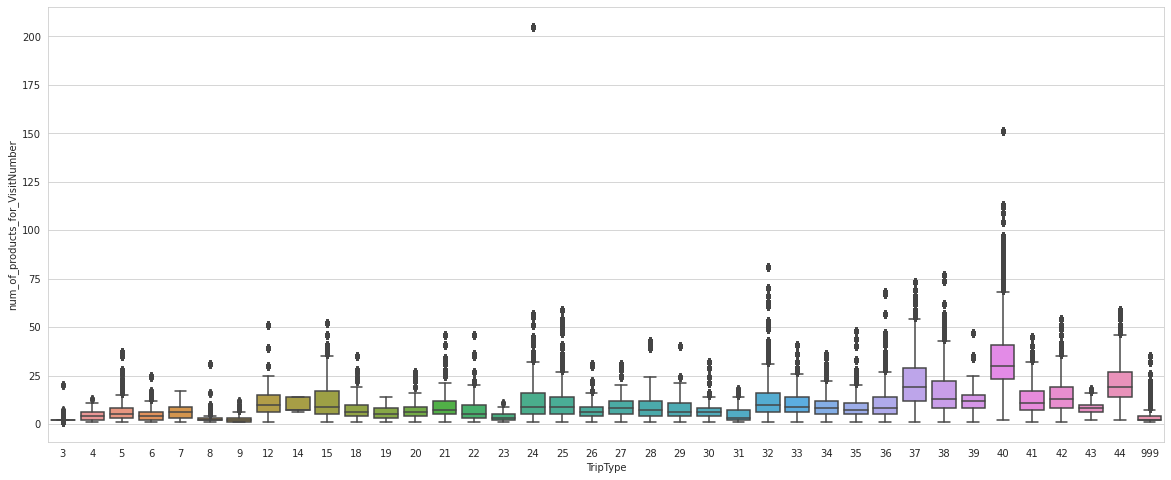

In [85]:
plt.figure(figsize=(20,8))
sns.boxplot(x='TripType',y='num_of_products_for_VisitNumber',data=train_d1)

**We do see a trend here, boxplots for various TripTypes for num_of_products don't fully overlap, hence num_of_products might prove to be a distinct feature**

In [86]:
train_d1.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,22
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,22


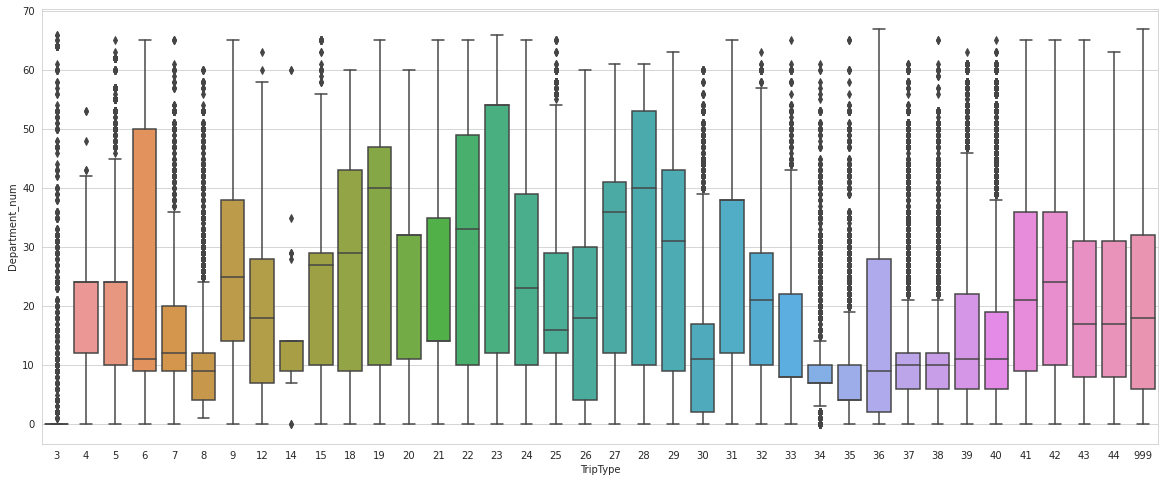

In [87]:
plt.figure(figsize=(20,8))
sns.boxplot(x='TripType',y='Department_num',data=train_d1)

**boxplots for various TripTypes for Department_num also don't fully overlap, hence num_of_products might prove to be a distinctive feature**

In [88]:
weekday_num_of_products=dict(train_d1.groupby('weekday_num')['Upc'].count())

In [89]:
train_d1['num_of_products_for_weekday']=train_d1['weekday_num'].apply(lambda x:weekday_num_of_products.get(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [90]:
train_d1.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_weekday
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1,94909
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2,94909
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2,94909
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,22,94909
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,22,94909


In [91]:
train_d1.num_of_products_for_weekday.nunique()

7

Correctly it has a value for each weekday that's why shows 7.

In [92]:
train_d1.num_of_products_for_weekday.unique()

array([ 94909, 120568, 132571,  82020,  71365,  69994,  67045])

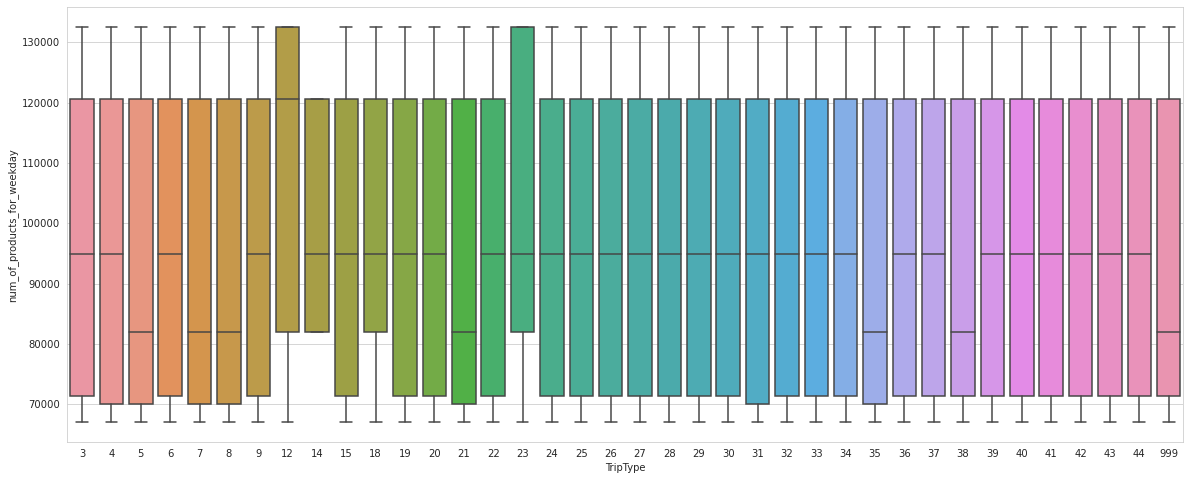

In [93]:
plt.figure(figsize=(20,8))
sns.boxplot(x='TripType',y='num_of_products_for_weekday',data=train_d1)

**'num_of_products_for weekday' does not seem to be much useful. removing it**

In [94]:
train_d1.drop(columns=['num_of_products_for_weekday'],inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [95]:
Department_num_of_products=dict(train_d1.groupby('Department_num')['Upc'].count())

In [96]:
train_d1['num_of_products_for_each_department']=train_d1['Department_num'].apply(lambda x:Department_num_of_products.get(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


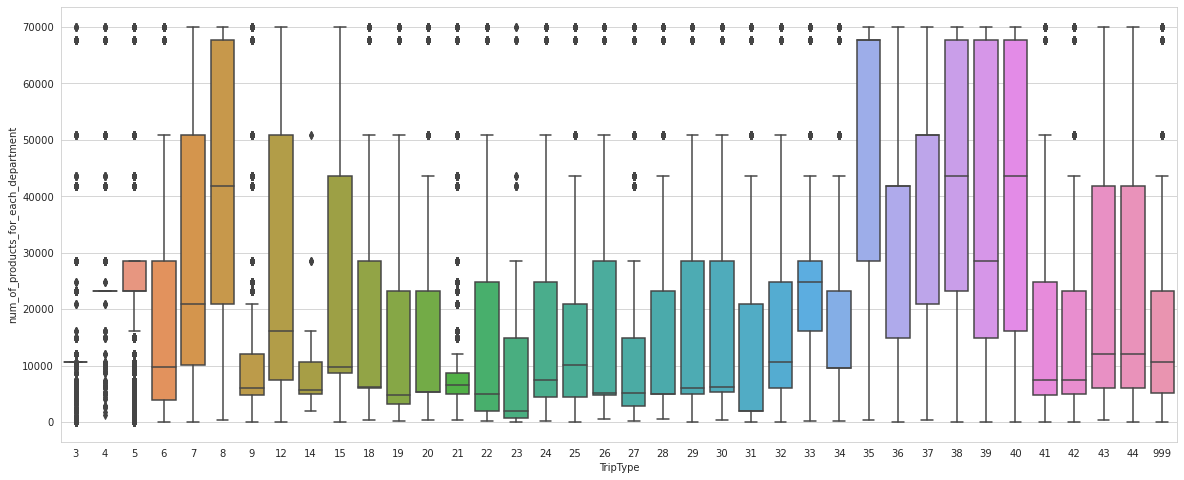

In [97]:
plt.figure(figsize=(20,8))
sns.boxplot(x='TripType',y='num_of_products_for_each_department',data=train_d1)

**'num_of_products_for_department' seems to be useful. keeping it.**

In [98]:
train_data.FinelineNumber.nunique()

5195

In [99]:
Fineline_num_of_products=dict(train_d1.groupby('FinelineNumber')['Upc'].count())

In [100]:
train_d1['num_of_products_for_fineline']=train_d1['FinelineNumber'].apply(lambda x:Fineline_num_of_products.get(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


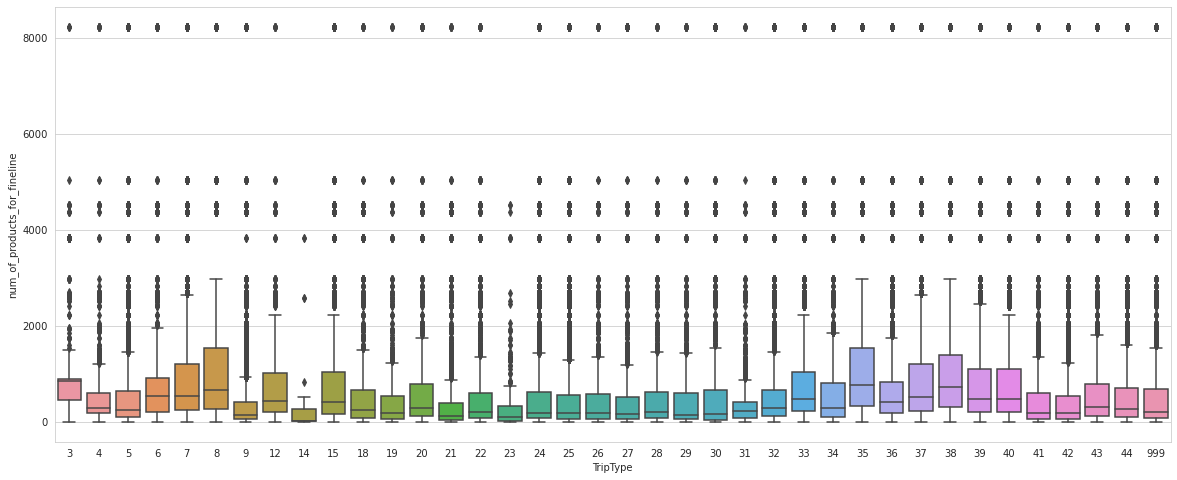

In [101]:
plt.figure(figsize=(20,8))
sns.boxplot(x='TripType',y='num_of_products_for_fineline',data=train_d1)

**num_of_products_for_fineline' does not seem to be much useful removing it- as expected since both variables correspond to a particular product**

In [102]:
train_d1.drop(columns=['num_of_products_for_fineline'],inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [103]:
train_d1.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_each_department
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1,10713
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2,6056
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2,41887
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,22,1698
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,22,1698


In [104]:
train_d1.Weekday.value_counts()

Sunday       132571
Saturday     120568
Friday        94909
Monday        82020
Tuesday       71365
Wednesday     69994
Thursday      67045
Name: Weekday, dtype: int64

In [105]:
train_d1.DepartmentDescription.value_counts()

GROCERY DRY GOODS         70034
DSD GROCERY               67682
PRODUCE                   50826
DAIRY                     43599
PERSONAL CARE             41887
                          ...  
LARGE HOUSEHOLD GOODS        77
CONCEPT STORES               35
SEASONAL                     29
OTHER DEPARTMENTS            29
HEALTH AND BEAUTY AIDS        2
Name: DepartmentDescription, Length: 68, dtype: int64

## **one hot encoding Weekdays**

In [106]:
one_hot_encoded_weekday=pd.get_dummies(train_d1['Weekday'],drop_first=False)

In [107]:
one_hot_encoded_weekday.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [108]:
train_d1=pd.concat([train_d1,one_hot_encoded_weekday],axis=1)

In [109]:
train_d1.shape

(638472, 18)

In [110]:
train_d1.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_each_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1,10713,1,0,0,0,0,0,0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2,6056,1,0,0,0,0,0,0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2,41887,1,0,0,0,0,0,0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,22,1698,1,0,0,0,0,0,0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,22,1698,1,0,0,0,0,0,0


# Splitting data into X and Y and then into train and cross validation and test sets.

**adding 'FinelineCat' feature**

In [138]:
Y=train_d1.TripType
Y=pd.DataFrame(Y)

In [140]:
Y.head()

,TripType
0,999
1,30
2,30
3,26
4,26


In [112]:
X=train_d1.drop(columns=['TripType'])

In [113]:
train_d1.FinelineNumber.nunique()

5195

In [114]:
train_d1.TripType.nunique()

38

In [115]:
X['FinelineCat']=pd.cut(X['FinelineNumber'],bins=50,labels=False)

X['FinelineNumber'] accesses the 'FinelineNumber' column of the DataFrame 'X'.
pd.cut() is applied to the 'FinelineNumber' column. It divides the values into specified bins based on the given number of bins or bin edges.
In this case, bins=50 specifies that the values should be divided into 50 equal-width bins.
The labels=False argument indicates that the resulting bins should be represented by integer labels instead of categorical labels.
The resulting 'FinelineCat' column in the 'X' DataFrame will contain the bin labels corresponding to each value in the 'FinelineNumber' column. The labels are integers ranging from 0 to 49, indicating which bin each value falls into.

This type of binning can be useful for converting continuous numerical variables into categorical or ordinal representations, allowing for easier analysis or modeling.

In [116]:
X.shape

(638472, 18)

In [117]:
X.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_each_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,FinelineCat
0,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1,10713,1,0,0,0,0,0,0,5
1,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2,6056,1,0,0,0,0,0,0,44
2,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2,41887,1,0,0,0,0,0,0,22
3,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,22,1698,1,0,0,0,0,0,0,17
4,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,22,1698,1,0,0,0,0,0,0,5


In [128]:
X.drop(columns=['Weekday','Upc','DepartmentDescription'],inplace=True)

In [141]:
X.head()

,VisitNumber,ScanCount,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_each_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,FinelineCat
0,5,-1,1000.0,4,0,1,10713,1,0,0,0,0,0,0,5
1,7,1,8931.0,4,1,2,6056,1,0,0,0,0,0,0,44
2,7,1,4504.0,4,2,2,41887,1,0,0,0,0,0,0,22
3,8,2,3565.0,4,3,22,1698,1,0,0,0,0,0,0,17
4,8,2,1017.0,4,3,22,1698,1,0,0,0,0,0,0,5


In [142]:
Y.head()

,TripType
0,999
1,30
2,30
3,26
4,26


In [143]:
train_d1.shape

(638472, 18)

In [144]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,stratify=Y,test_size=0.2)

The stratify=Y parameter ensures that the train-test split is stratified based on the values in Y, maintaining the same class distribution in both the training and testing sets.

In [145]:
print(x_train.shape,x_test.shape)

(510777, 15) (127695, 15)


In [146]:
x_train.head()

,VisitNumber,ScanCount,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_each_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,FinelineCat
346950,102951,1,3534.0,6,24,15,23243,0,0,0,1,0,0,0,17
414335,122933,1,1104.0,2,12,7,70034,0,0,0,0,0,0,1,5
334280,99834,1,1515.0,6,6,11,43599,0,0,0,1,0,0,0,7
206056,60971,1,3186.0,6,2,112,41887,0,0,0,1,0,0,0,15
274610,81971,1,5004.0,3,7,1,9607,0,0,0,0,1,0,0,25


In [147]:
print(y_train.shape,y_test.shape)

(510777, 1) (127695, 1)


# Response/Target encoding for rest of the categorical features

### **Creating a new temporary dataframe from x_train and y_train for getting lookup table for response coding of some categorical features**

In [174]:
x_train_res=x_train.copy()

In [175]:
x_train_res['class']=y_train.values

In [176]:
y_train.unique()

array([ 38,  44,  37,  39,  40,  15,  33,  35,  43, 999,  30,   3,  25,
        41,  42,   9,  34,  27,  32,   7,   5,  36,  29,  24,  20,  22,
         8,  21,  18,   4,   6,  31,  12,  28,  19,  26,  23,  14])

In [178]:
x_train_res.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_each_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,FinelineCat,class
204922,60676,Sunday,7.047029e+09,1,DAIRY,1344.0,6,6,13,43599,0,0,0,1,0,0,0,6,38
330177,98783,Saturday,3.500067e+09,1,PERSONAL CARE,801.0,5,2,26,41887,0,0,1,0,0,0,0,4,44
2645,1099,Friday,7.874207e+09,1,GROCERY DRY GOODS,3809.0,4,12,18,70034,1,0,0,0,0,0,0,19,37
289578,86851,Friday,8.559350e+10,1,MENS WEAR,1900.0,4,16,9,12138,1,0,0,0,0,0,0,9,39
266968,79613,Wednesday,7.874223e+09,1,GROCERY DRY GOODS,4451.0,2,12,48,70034,0,0,0,0,0,0,1,22,40


### **Functions for response encoding** 

The function takes two parameters:

alpha: A smoothing parameter used for Laplace smoothing.
feature: The name of the feature/column for which the lookup dictionary needs to be generated.
The function calculates the count of each unique value in the feature column of the x_train_res DataFrame using value_counts(). Then, it iterates over each unique value and calculates the Laplace smoothed probability for each class value in the y_train variable.

The resulting lookup dictionary stores the Laplace smoothed probabilities for each unique value of the feature column, where each value corresponds to a list of probabilities for each class.

The tqdm library is used to display a progress bar during the iteration over the unique values.

A lookup dictionary, also known as a mapping dictionary or key-value dictionary, is a data structure that maps keys to corresponding values. It provides an efficient way to retrieve values based on their associated keys.

In Python, a lookup dictionary is implemented using the built-in dict data type. It consists of key-value pairs, where each key is unique within the dictionary, and each key is associated with a specific value.

In this code, value_count is a pandas Series object obtained from the value_counts() function, which counts the occurrences of each unique value in the feature column. The items() method is used to iterate over the unique values and their corresponding counts.

For each iteration, denominator represents the count of a specific unique value. It serves as a denominator in the Laplace smoothing formula to calculate the probabilities for each class associated with that unique value.

The purpose of using denominator in the formula is to normalize the count of occurrences of a unique value and avoid division by zero. It ensures that the probabilities are appropriately adjusted to account for the overall distribution of the unique values.

By dividing the count of occurrences for a specific class value (cls_cnt.shape[0] + alpha*10) by the sum of the count of occurrences for the unique value across all class values (denominator + 90*alpha), Laplace smoothing is applied to calculate the probabilities.

In summary, denominator represents the count of a specific unique value, and it is used as part of the Laplace smoothing formula to calculate the probabilities for each class associated with that unique value.

In [180]:
#function to get lookup dictionary based on train data only
from tqdm import tqdm
def get_lookup_dict(alpha,feature):
  value_count = x_train_res[feature].value_counts()
  lookup_dict = dict()
  for i, denominator in tqdm(value_count.items()):
    vec = []
    for k in y_train.unique():
      cls_cnt = x_train_res.loc[(x_train_res['class']==k) & (x_train_res[feature]==i)]
      vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
    
    lookup_dict[i]=vec
  
  return lookup_dict


The function takes four parameters:

alpha: A smoothing parameter used in the lookup dictionary generation.
feature: The name of the feature/column for which encoded features are calculated.
df: The DataFrame for which the encoded features are calculated.
lookup_dict: A precomputed lookup dictionary obtained from the get_lookup_dict() function.
Within the function, value_count represents the count of occurrences of each unique value in the feature column of the x_train_res DataFrame.

The loop iterates over each row in the input DataFrame (df) using iterrows(). For each row, it checks if the value in the feature column exists in the keys of the value_count dictionary. If it does, it appends the corresponding encoded value from the lookup_dict to the gv_fea list. Otherwise, it appends a default value of [1/38] * 38.

The default value [1/38] * 38 suggests that if a value in the feature column of the input DataFrame does not exist in the lookup dictionary, a uniform probability distribution is assumed among all classes. The length of the default value list (38) corresponds to the number of classes.

The resulting gv_fea list contains the encoded features for each row in the input DataFrame.

In [181]:
from tqdm import tqdm
def get_encoded_feature(alpha,feature,df,lookup_dict):
  #lookup_dict=get_lookup_dict(alpha,feature,df)
  value_count = x_train_res[feature].value_counts()
  gv_fea = []
  for index, row in tqdm(df.iterrows()):

    if row[feature] in dict(value_count).keys():
        gv_fea.append(lookup_dict[row[feature]])
    else:
        gv_fea.append([1/38]*38)
#           gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
  
  return gv_fea

In [189]:
train_d1.TripType.nunique()

38

### **response encoding 'DepartmentDescription'**

In [182]:
lookup_dict_DD=get_lookup_dict(1,'DepartmentDescription')

68it [02:56,  2.59s/it]


In [183]:
alpha = 1
train_department_feature_responseCoding=np.array(get_encoded_feature(alpha, "DepartmentDescription", x_train,lookup_dict_DD))

408621it [11:05, 614.22it/s]


In [184]:
test_department_feature_responseCoding=np.array(get_encoded_feature(alpha, "DepartmentDescription", x_test,lookup_dict_DD))

127695it [03:28, 612.61it/s]


In [185]:
cv_department_feature_responseCoding=np.array(get_encoded_feature(alpha, "DepartmentDescription", x_cv,lookup_dict_DD))

102156it [02:47, 610.87it/s]


In [187]:
train_department_feature_responseCoding.shape

(408621, 38)

In [186]:
test_department_feature_responseCoding.shape

(127695, 38)

In [188]:
cv_department_feature_responseCoding.shape

(102156, 38)

### **response encoding 'ScanCount'**

In [190]:
train_d1.ScanCount.nunique()

39

In [191]:
lookup_dict_SS=get_lookup_dict(1,'ScanCount')

36it [00:03, 10.69it/s]


In [192]:
train_ScanCount_feature_responseCoding=np.array(get_encoded_feature(alpha, "ScanCount", x_train,lookup_dict_SS))

408621it [06:48, 1000.80it/s]


In [193]:
test_ScanCount_feature_responseCoding=np.array(get_encoded_feature(alpha, "ScanCount", x_test,lookup_dict_SS))

127695it [02:07, 1004.79it/s]


In [194]:
cv_ScanCount_feature_responseCoding=np.array(get_encoded_feature(alpha, "ScanCount", x_cv,lookup_dict_SS))

102156it [01:42, 997.09it/s] 


In [195]:
train_ScanCount_feature_responseCoding.shape

(408621, 38)

In [196]:
test_ScanCount_feature_responseCoding.shape

(127695, 38)

In [197]:
cv_ScanCount_feature_responseCoding.shape

(102156, 38)

### **response encoding 'FinelineCat'**

In [199]:
train_d1.FinelineNumber.nunique()

5195

'FinelineNumber' has too many categories. we will try to discretise it further into small number of categories

In [200]:
train_d1.FinelineNumber

0         1000.0
1         8931.0
2         4504.0
3         3565.0
4         1017.0
           ...  
647049    1118.0
647050    1752.0
647051    4170.0
647052    1512.0
647053    3600.0
Name: FinelineNumber, Length: 638472, dtype: float64

In [201]:
train_d1['FinelineCat']=pd.cut(train_data['FinelineNumber'],bins=50,labels=False)

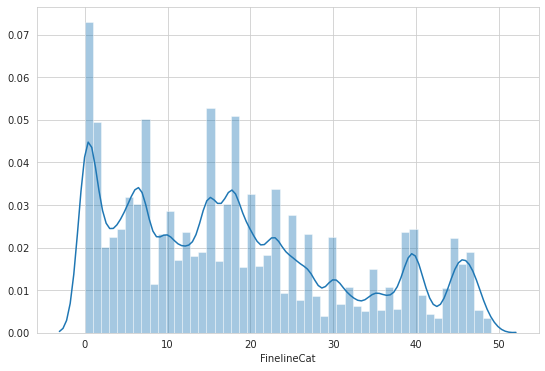

In [202]:
plt.figure(figsize=(9,6))
sns.distplot(train_d1['FinelineCat'])

we will see if this new feature is useful in classification

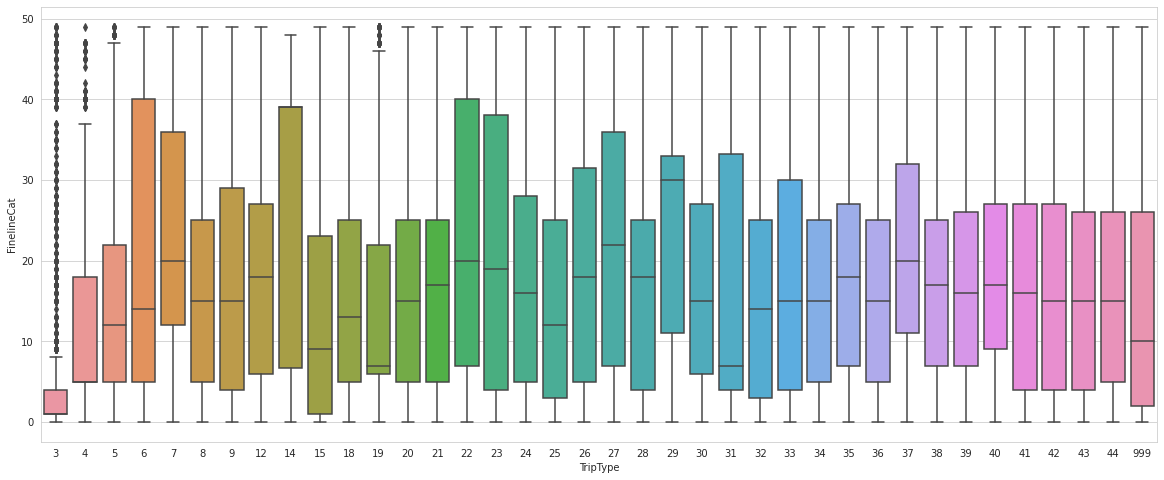

In [203]:
plt.figure(figsize=(20,8))
sns.boxplot(x='TripType',y='FinelineCat',data=train_d1)

Not much useful. but we will anyway respose encode this feature

we will need to add this feature to X first

In [204]:
lookup_dict_FNC=get_lookup_dict(1,'FinelineCat')

50it [00:05,  9.89it/s]


In [205]:
train_FinelineCat_feature_responseCoding=np.array(get_encoded_feature(alpha, "FinelineCat", x_train,lookup_dict_FNC))

408621it [09:02, 752.67it/s]


In [206]:
test_FinelineCat_feature_responseCoding=np.array(get_encoded_feature(alpha, "FinelineCat", x_test,lookup_dict_FNC))

127695it [02:49, 755.21it/s]


In [207]:
cv_FinelineCat_feature_responseCoding=np.array(get_encoded_feature(alpha, "FinelineCat", x_cv,lookup_dict_FNC))

102156it [02:14, 758.32it/s]


In [208]:
train_FinelineCat_feature_responseCoding.shape

(408621, 38)

In [209]:
test_FinelineCat_feature_responseCoding.shape

(127695, 38)

In [210]:
cv_FinelineCat_feature_responseCoding.shape

(102156, 38)

# Stacking all featurized train, test and cv data and preparing final data.

In [211]:
x_train.shape

(408621, 18)

In [213]:
x_train.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_each_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,FinelineCat
204922,60676,Sunday,7.047029e+09,1,DAIRY,1344.0,6,6,13,43599,0,0,0,1,0,0,0,6
330177,98783,Saturday,3.500067e+09,1,PERSONAL CARE,801.0,5,2,26,41887,0,0,1,0,0,0,0,4
2645,1099,Friday,7.874207e+09,1,GROCERY DRY GOODS,3809.0,4,12,18,70034,1,0,0,0,0,0,0,19
289578,86851,Friday,8.559350e+10,1,MENS WEAR,1900.0,4,16,9,12138,1,0,0,0,0,0,0,9
266968,79613,Wednesday,7.874223e+09,1,GROCERY DRY GOODS,4451.0,2,12,48,70034,0,0,0,0,0,0,1,22


In [217]:
xt.drop(columns=['Weekday','Upc','DepartmentDescription','FinelineNumber','weekday_num','Department_num','FinelineCat'],inplace=True,axis=1)

KeyError: "['Weekday' 'Upc' 'DepartmentDescription' 'FinelineNumber' 'weekday_num'\n 'Department_num' 'FinelineCat'] not found in axis"

In [221]:
x_train.head()

,VisitNumber,ScanCount,num_of_products_for_VisitNumber,num_of_products_for_each_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
204922,60676,1,13,43599,0,0,0,1,0,0,0
330177,98783,1,26,41887,0,0,1,0,0,0,0
2645,1099,1,18,70034,1,0,0,0,0,0,0
289578,86851,1,9,12138,1,0,0,0,0,0,0
266968,79613,1,48,70034,0,0,0,0,0,0,1


In [222]:
x_train.values

array([[ 60676,      1,     13, ...,      0,      0,      0],
       [ 98783,      1,     26, ...,      0,      0,      0],
       [  1099,      1,     18, ...,      0,      0,      0],
       ...,
       [ 42611,      1,     32, ...,      1,      0,      0],
       [ 36450,      1,     13, ...,      0,      0,      1],
       [103116,     -3,      3, ...,      0,      0,      0]])

In [223]:
x_train.values.shape

(408621, 11)

In [224]:
x_tr=np.hstack((x_train.values,train_ScanCount_feature_responseCoding,train_department_feature_responseCoding,train_FinelineCat_feature_responseCoding,))

In [226]:
#total columns = 11+38+38+38
x_tr.shape

(408621, 125)

In [227]:
y_train.shape

(408621,)

In [228]:
x_test.drop(columns=['Weekday','Upc','DepartmentDescription','FinelineNumber','weekday_num','Department_num','FinelineCat'],inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [229]:
x_test.head()

,VisitNumber,ScanCount,num_of_products_for_VisitNumber,num_of_products_for_each_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
16210,5248,1,6,9717,1,0,0,0,0,0,0
89166,25328,1,10,14839,0,1,0,0,0,0,0
585909,175013,1,35,14839,1,0,0,0,0,0,0
503411,149076,1,10,9453,0,0,0,1,0,0,0
91811,26168,1,1,23243,0,0,0,0,0,1,0


In [233]:
x_test.shape

(127695, 11)

In [230]:
x_te=np.hstack((x_test.values,test_ScanCount_feature_responseCoding,test_department_feature_responseCoding,test_FinelineCat_feature_responseCoding,))

In [234]:
x_te.shape

(127695, 125)

In [231]:
x_cv.drop(columns=['Weekday','Upc','DepartmentDescription','FinelineNumber','weekday_num','Department_num','FinelineCat'],inplace=True)

In [232]:
x_cv=np.hstack((x_cv.values,cv_ScanCount_feature_responseCoding,cv_department_feature_responseCoding,cv_FinelineCat_feature_responseCoding,))

In [236]:
x_cv.shape

(102156, 125)

In [237]:
y_cv.shape

(102156,)

## saving the three preprocessed and featurized train, test and cv datasets for future importing.

In [238]:
np.save(r'/kaggle/working/x_train_final',x_tr)

In [239]:
np.save(r'/kaggle/working/x_test_final',x_te)

In [240]:
np.save(r'/kaggle/working/x_cv_final',x_cv)

In [241]:
np.save(r'/kaggle/working/y_train_final',y_train.values)

In [242]:
np.save(r'/kaggle/working/y_test_final',y_test.values)

In [243]:
np.save(r'/kaggle/working/y_cv_final',y_cv.values)

In [245]:
y_cv.values.shape

(102156,)

## loading .npy files

In [166]:
from scipy import sparse

In [167]:
x_cv=sparse.csr_matrix(np.load('/kaggle/working/x_cv_final.npy'))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/x_cv_final.npy'

In [319]:
type(x_cv)

scipy.sparse.csr.csr_matrix

In [320]:
x_test=sparse.csr_matrix(np.load('/kaggle/working/x_test_final.npy'))

In [321]:
x_train=sparse.csr_matrix(np.load('/kaggle/working/x_train_final.npy'))

In [335]:
y_cv=np.load('/kaggle/working/y_cv_final.npy')

In [336]:
y_test=np.load('/kaggle/working/y_test_final.npy')

In [337]:
y_train=np.load('/kaggle/working/y_train_final.npy')

In [338]:
y_train.shape[0]+y_cv.shape[0]

510777

In [339]:
x_train.shape[0]+x_cv.shape[0]

612933

In [340]:
print(x_train.shape,x_cv.shape,x_test.shape)

(510777, 125) (102156, 125) (127695, 125)


In [341]:
print(y_train.shape,y_cv.shape,y_test.shape)

(408621,) (102156,) (127695,)


In [342]:
408621+102156

510777

Joining train and cv datasets since we are going to use sklearn's cross validation implementation and not manual

In [343]:
from scipy.sparse import vstack


In [331]:
x_train=vstack((x_train,x_cv))

In [332]:
x_train.shape,type(x_train)

((510777, 125), scipy.sparse.csr.csr_matrix)

In [345]:
y_train=np.vstack((y_train.reshape(-1,1),y_cv.reshape(-1,1)))

In [346]:
y_train.shape

(510777, 1)

In [347]:
y_train=y_train.astype('int')

In [348]:
y_train.dtype

dtype('int64')

# Performing RandomSearchCv to check for best hyperparameters for RondomForestClassifier

In [265]:
random_grid = {'max_depth': [None],
               'min_samples_leaf': [100,1000],
               'min_samples_split': [100,1000],
               'n_estimators': [100,500]}

In [266]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

best parameters:

In [ ]:
rf_random.best_params_


In [ ]:
rf_random.best_estimator_

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# Training RandomForestClassifier with best parameters

In [ ]:

r_cfl=RandomForestClassifier(n_estimators=500,max_depth=None,min_samples_leaf=100,min_samples_split=100, random_state=42,n_jobs=-1)
r_cfl.fit(x_train,y_train)


In [ ]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)

In [ ]:
pred=r_cfl.predict(x_cv)

# Training CalibratedClassifier on top of our base Classifier to get calibrated probabilities

In [ ]:
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(x_train, y_train)
predict_y = sig_clf.predict_proba(x_cv)
loss=log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15)

In [ ]:
loss

## **the RandomForestClassifier with parameters: 'max_depth' = None, 'min_samples_leaf' = 100, 'min_samples_split' = 100, 'n_estimators' = 500 gives log-loss of 1.85 on cross validation data**

# Training a completely random model to check worst possible log-loss

In [ ]:
#test_data_len = X_test.shape[0]
cv_data_len = x_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,38))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,38)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

## **worst possoble log-loss of a completely random model is 3.94**

##**Log-Loss for totally random model is 3.94 and for our RandomForestClassifier, log-loss is 1.84 i.e less than half of random model. Our model seems to be performing well.**